In [324]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from statsmodels.formula.api import ols

## Data Partitioning

In [325]:
df = pd.read_csv("2019-2020 NBA Play-By-Play Data.csv", low_memory=False)

away_ids = ['a1', 'a2', 'a3', 'a4', 'a5']
home_ids = ['h1', 'h2', 'h3', 'h4']
ids = away_ids + home_ids

attributes = ['period', 'away_score', 'home_score', 'play_length', 'assist', 
              'block', 'num', 'opponent', 'outof', 'player', 'points', 'steal', 
              'type', 'shot_distance', 'original_x', 'original_y', 
              'converted_x', 'converted_y', 'description']

def get_location(row):
    lebron_away = any(row.get(col) == 'LeBron James' for col in away_ids)
    lebron_home = any(row.get(col) == 'LeBron James' for col in home_ids)
    ad_away = any(row.get(col) == 'Anthony Davis' for col in away_ids)
    ad_home = any(row.get(col) == 'Anthony Davis' for col in home_ids)

    if lebron_home and ad_home:
        return "both_home"
    elif lebron_away and ad_away:
        return "both_away"
    elif lebron_home and not ad_home and not ad_away:
        return "lebron_home"
    elif lebron_away and not ad_home and not ad_away:
        return "lebron_away"
    elif ad_home and not lebron_home and not lebron_away:
        return "ad_home"
    elif ad_away and not lebron_home and not lebron_away:
        return "ad_away"
    else:
        return "none"
    
df["player_location"] = df.apply(get_location, axis=1)

filtered_df = df[df["player_location"] != "none"]

final_df = filtered_df[['player_location'] + attributes]

df_lebron = final_df[final_df["player_location"].str.startswith("lebron")].reset_index(drop=True)
df_ad = final_df[final_df["player_location"].str.startswith("ad")].reset_index(drop=True)
df_both = final_df[final_df["player_location"].str.startswith("both")].reset_index(drop=True)

df_both.head()

,player_location,period,away_score,home_score,play_length,assist,block,num,opponent,outof,player,points,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
0,both_home,1,0,0,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN
1,both_home,1,0,0,00:00:00,NaN,NaN,NaN,NaN,NaN,JaVale McGee,NaN,NaN,jump ball,NaN,NaN,NaN,NaN,NaN,Jump Ball McGee vs. Favors: Tip to Davis
2,both_home,1,0,2,00:00:19,LeBron James,NaN,NaN,NaN,NaN,Anthony Davis,2.0,NaN,unknown,2.0,14.0,11.0,26.4,87.9,Davis 2' Cutting Dunk Shot (2 PTS) (James 1 AST)
3,both_home,1,3,2,00:00:15,JJ Redick,NaN,NaN,NaN,NaN,Lonzo Ball,3.0,NaN,Jump Shot,25.0,114.0,226.0,13.6,27.6,Ball 25' 3PT Jump Shot (3 PTS) (Redick 1 AST)
4,both_home,1,3,4,00:00:18,LeBron James,NaN,NaN,NaN,NaN,Anthony Davis,2.0,NaN,Alley Oop Layup,2.0,-20.0,10.0,23.0,88.0,Davis 2' Alley Oop Layup (4 PTS) (James 2 AST)


In [326]:
df_lebron.head()

,player_location,period,away_score,home_score,play_length,assist,block,num,opponent,outof,player,points,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
0,lebron_home,2,46,53,00:00:00,NaN,NaN,NaN,NaN,NaN,Kyle Kuzma,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Bradley FOR Kuzma
1,lebron_home,2,46,53,00:00:00,NaN,NaN,NaN,NaN,NaN,Rajon Rondo,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Davis FOR Rondo
2,lebron_home,4,83,105,00:-12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN
3,lebron_home,4,83,105,00:00:12,NaN,NaN,NaN,NaN,NaN,Kentavious Caldwell-Pope,0.0,NaN,Jump Shot,27.0,26.0,264.0,27.6,62.6,MISS Caldwell-Pope 27' 3PT Jump Shot
4,lebron_home,4,83,105,00:00:03,NaN,NaN,NaN,NaN,NaN,E'Twaun Moore,NaN,NaN,rebound defensive,NaN,NaN,NaN,NaN,NaN,Moore REBOUND (Off:0 Def:2)


In [327]:
df_ad.head()

,player_location,period,away_score,home_score,play_length,assist,block,num,opponent,outof,player,points,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
0,ad_home,1,22,39,00:00:00,NaN,NaN,NaN,NaN,NaN,LeBron James,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Rondo FOR James
1,ad_home,1,22,39,00:00:00,NaN,NaN,NaN,NaN,NaN,Brandon Ingram,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Hart FOR Ingram
2,ad_home,1,23,39,00:00:00,NaN,NaN,2.0,NaN,2.0,Jrue Holiday,1.0,NaN,Free Throw 2 of 2,NaN,NaN,NaN,NaN,NaN,Holiday Free Throw 2 of 2 (4 PTS)
3,ad_home,1,23,39,00:00:03,NaN,NaN,NaN,NaN,NaN,Rajon Rondo,NaN,NaN,out of bounds lost ball turnover,NaN,NaN,NaN,NaN,NaN,Rondo Out of Bounds Lost Ball Turnover (P1.T3)
4,ad_home,1,25,39,00:00:09,Jrue Holiday,NaN,NaN,NaN,NaN,Jaxson Hayes,2.0,NaN,unknown,3.0,4.0,25.0,24.6,7.5,Hayes 3' Cutting Dunk Shot (4 PTS) (Holiday 1 ...


## EDA Summary

In [328]:
def split_attributes(df, attributes):
    numerical_attrs = []
    non_numerical_attrs = []
    
    for attr in attributes:
        if pd.api.types.is_numeric_dtype(df[attr]):
            numerical_attrs.append(attr)
        else:
            non_numerical_attrs.append(attr)
    
    return numerical_attrs, non_numerical_attrs

numerical_attributes, non_numerical_attributes = split_attributes(df_both, attributes)

print("Numerical Attributes:", numerical_attributes)
print("Non-Numerical Attributes:", non_numerical_attributes)

Numerical Attributes: ['period', 'away_score', 'home_score', 'num', 'outof', 'points', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y']
Non-Numerical Attributes: ['play_length', 'assist', 'block', 'opponent', 'player', 'steal', 'type', 'description']


In [329]:
def advanced_summary(df, columns):
    summary_df = pd.DataFrame(index=columns)

    summary_df['count'] = df[columns].count()
    summary_df['mean'] = df[columns].mean()
    summary_df['std'] = df[columns].std()
    summary_df['min'] = df[columns].min()
    summary_df['25%'] = df[columns].quantile(0.25)
    summary_df['50%'] = df[columns].median()
    summary_df['75%'] = df[columns].quantile(0.75)
    summary_df['max'] = df[columns].max()
    summary_df['missing'] = df[columns].isnull().sum()
    summary_df['skew'] = df[columns].skew()
    summary_df['kurtosis'] = df[columns].kurtosis()

    return summary_df

numerical_summary = advanced_summary(df_both, numerical_attributes)
print(numerical_summary)

               count       mean         std    min    25%   50%    75%    max  \
period         17098   2.444906    1.151165    1.0   1.00   3.0    3.0    5.0   
away_score     17098  53.073927   35.215607    0.0  15.00  57.0   80.0  130.0   
home_score     17098  54.524740   35.164966    0.0  16.00  59.0   82.0  139.0   
num             1700   1.484118    0.559876    1.0   1.00   1.0    2.0    3.0   
outof           1700   1.927647    0.432699    1.0   2.00   2.0    2.0    3.0   
points          8116   0.998275    1.070870    0.0   0.00   1.0    2.0    3.0   
shot_distance   6391  13.766860   10.640892    0.0   2.00  14.0   25.0   66.0   
original_x      6391  -2.957753  114.889278 -244.0 -54.00   0.0   40.0  249.0   
original_y      6391  90.925364   93.624610  -27.0  12.50  46.0  174.0  640.0   
converted_x     6391  25.221358   11.490603    0.6  20.65  25.0   30.1   49.9   
converted_y     6391  47.024535   34.215869    2.3   9.20  59.7   84.1   91.5   

               missing     

In [330]:
numerical_summary = advanced_summary(df_lebron, numerical_attributes)
print(numerical_summary)

               count       mean         std    min   25%   50%    75%    max  \
period         10667   2.669354    1.068655    1.0   2.0   2.0    4.0    5.0   
away_score     10667  56.227805   31.082224    0.0  31.0  50.0   85.0  128.0   
home_score     10667  56.919003   30.439770    0.0  32.0  50.0   86.0  124.0   
num             1000   1.481000    0.554930    1.0   1.0   1.0    2.0    3.0   
outof           1000   1.926000    0.434411    1.0   2.0   2.0    2.0    3.0   
points          4929   0.999188    1.082625    0.0   0.0   1.0    2.0    3.0   
shot_distance   3911  13.746101   10.664242    0.0   2.0  13.0   25.0   64.0   
original_x      3911  -1.723089  114.989902 -245.0 -48.0   0.0   37.0  250.0   
original_y      3911  90.340322   94.246770  -25.0  12.0  42.0  174.0  643.0   
converted_x     3911  24.983252   11.500269    0.5  20.6  25.0   29.0   50.0   
converted_y     3911  47.124546   34.290553    2.5   9.3  60.9   84.8   91.3   

               missing      skew  kurto

In [331]:
numerical_summary = advanced_summary(df_ad, numerical_attributes)
print(numerical_summary)

               count       mean         std    min    25%    50%      75%  \
period          9968   2.250201    1.023551    1.0   1.00   2.00    3.000   
away_score      9968  52.858949   29.265710    0.0  25.00  48.00   77.000   
home_score      9968  55.346007   29.449965    0.0  27.00  52.00   81.000   
num             1112   1.485612    0.543160    1.0   1.00   1.00    2.000   
outof           1112   1.938849    0.386358    1.0   2.00   2.00    2.000   
points          4638   0.996335    1.048628    0.0   0.00   1.00    2.000   
shot_distance   3508  13.750570   10.732546    0.0   3.00  13.00   25.000   
original_x      3508  -1.198974  113.929877 -246.0 -50.25   0.00   41.000   
original_y      3508  91.657925   95.160000  -38.0  14.00  46.00  173.000   
converted_x     3508  25.084493   11.393305    0.4  20.70  25.00   29.625   
converted_y     3508  47.024173   34.189856    1.2   9.80  48.75   84.600   

                 max  missing      skew  kurtosis  
period           4.0   

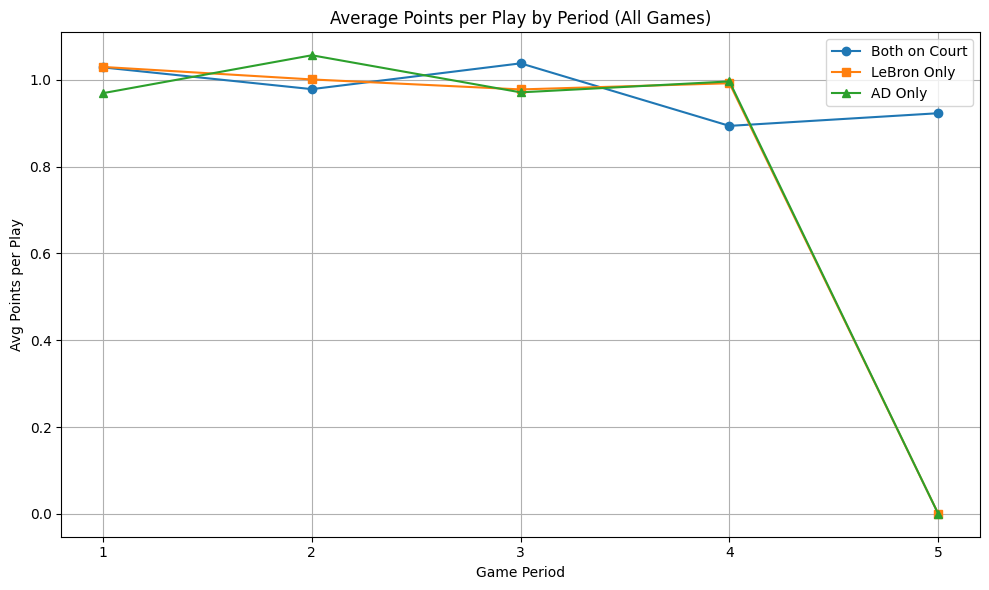

In [332]:
both_avg = df_both.groupby('period')['points'].mean().rename("Both").fillna(0)
lebron_avg = df_lebron.groupby('period')['points'].mean().rename("LeBron Only").fillna(0)
ad_avg = df_ad.groupby('period')['points'].mean().rename("AD Only").fillna(0)

points_by_period = pd.concat([both_avg, lebron_avg, ad_avg], axis=1).fillna(0)

plt.figure(figsize=(10, 6))
plt.plot(points_by_period.index, points_by_period["Both"], marker='o', label="Both on Court")
plt.plot(points_by_period.index, points_by_period["LeBron Only"], marker='s', label="LeBron Only")
plt.plot(points_by_period.index, points_by_period["AD Only"], marker='^', label="AD Only")

plt.title("Average Points per Play by Period (All Games)")
plt.xlabel("Game Period")
plt.ylabel("Avg Points per Play")
plt.xticks(points_by_period.index)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [333]:
df_both_shot = final_df[
    final_df['player_location'].str.startswith("both") &
    final_df['type'].str.lower().str.contains("shot", na=False)
].reset_index(drop=True)

df_lebron_shot = final_df[
    final_df['player_location'].str.startswith("lebron") &
    final_df['type'].str.lower().str.contains("shot", na=False) &
    (final_df['player'] == "LeBron James")
].reset_index(drop=True)

df_ad_shot = final_df[
    final_df['player_location'].str.startswith("ad") &
    final_df['type'].str.lower().str.contains("shot", na=False) &
    (final_df['player'] == "Anthony Davis")
].reset_index(drop=True)

In [334]:
def time_to_seconds(t):
    try:
        m, s = t.split(":")[-2:]
        return int(m) * 60 + int(s)
    except:
        return None
    
for df in [df_both_shot, df_lebron_shot, df_ad_shot]:
    df['play_length'] = df['play_length'].apply(time_to_seconds)

## Together, or spread them apart so they have one player on the court at all times?

In [335]:
def linear_shot_predictor(df_group, example_input, df_name):
    df_group = df_group.copy()
    if df_group['play_length'].dtype == 'object':
        df_group['play_length'] = df_group['play_length'].apply(time_to_seconds)

    df_group = df_group.dropna(subset=['shot_distance', 'play_length', 'period', 'points'])
    model = ols("points ~ shot_distance + play_length + period", data=df_group).fit()

    print(model.summary())

    predicted_points = model.predict(example_input)[0]
    print(f"Predicted points for this shot: {predicted_points:.2f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(df_group['shot_distance'], df_group['points'], alpha=0.4, label="Actual")
    predicted = model.predict(df_group)
    plt.plot(df_group['shot_distance'], predicted, color='red', linewidth=2, label="Regression Line")
    plt.title(f"Actual vs Predicted Points by Shot Distance for {df_name}")
    plt.xlabel("Shot Distance (feet)")
    plt.ylabel("Points")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return predicted_points

In [336]:
def knn_shot_predictor(df_group, example_input, k=5):
    shot_data = df_group.dropna(subset=['shot_distance', 'converted_x', 'converted_y', 'play_length', 'period', 'points']).copy()

    features = shot_data[['shot_distance', 'converted_x', 'converted_y', 'play_length', 'period']]
    target = (shot_data['points'] > 0).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    prob = knn.predict_proba(example_input)[0][1]
    print(f"Predicted scoring probability: {prob:.2%}")
    return prob

In [337]:
example_shot = pd.DataFrame([{
    'shot_distance': 15,
    'converted_x': 0,
    'converted_y': 20,
    'play_length': 12,  # seconds
    'period': 3
}])

## OLS Regression

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.845
Date:                Sun, 30 Mar 2025   Prob (F-statistic):              0.137
Time:                        13:52:20   Log-Likelihood:                -6579.3
No. Observations:                3972   AIC:                         1.317e+04
Df Residuals:                    3968   BIC:                         1.319e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1481      0.073     15.691

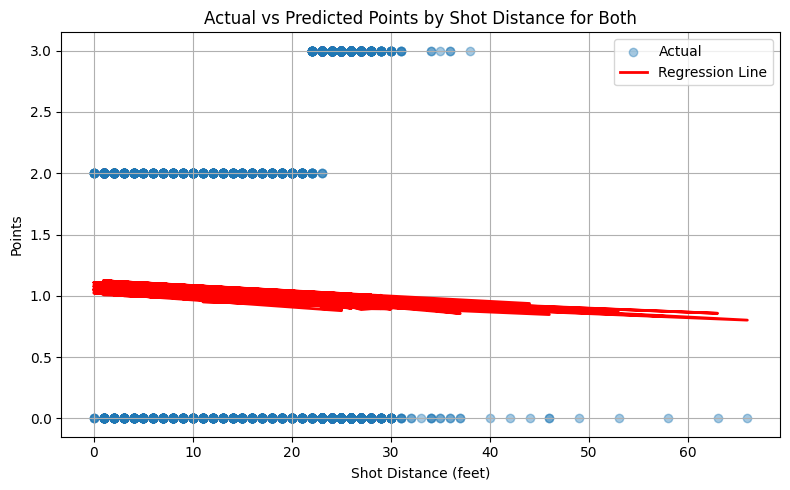

np.float64(0.9968853237346672)

In [338]:
linear_shot_predictor(df_both_shot, example_shot, "Both")

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2203
Date:                Sun, 30 Mar 2025   Prob (F-statistic):              0.882
Time:                        13:52:20   Log-Likelihood:                -506.99
No. Observations:                 302   AIC:                             1022.
Df Residuals:                     298   BIC:                             1037.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0723      0.307      3.489

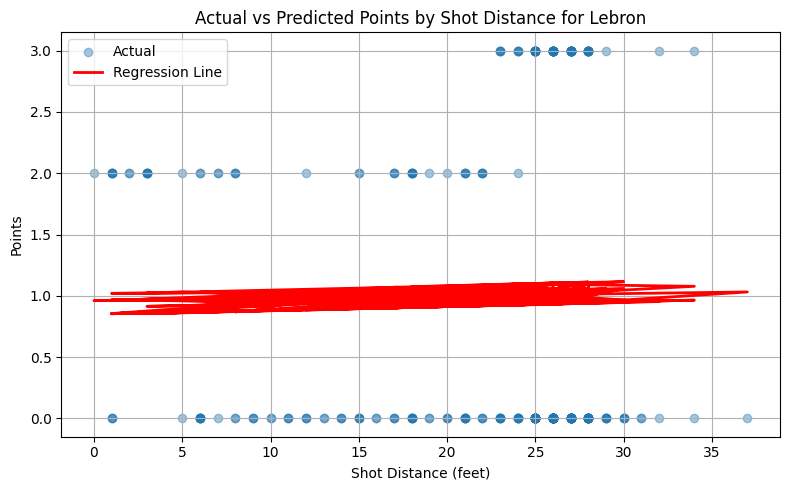

np.float64(0.9537139492629756)

In [339]:
linear_shot_predictor(df_lebron_shot, example_shot, "Lebron")

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.156
Date:                Sun, 30 Mar 2025   Prob (F-statistic):             0.0934
Time:                        13:52:20   Log-Likelihood:                -453.18
No. Observations:                 294   AIC:                             914.4
Df Residuals:                     290   BIC:                             929.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2830      0.216      5.942

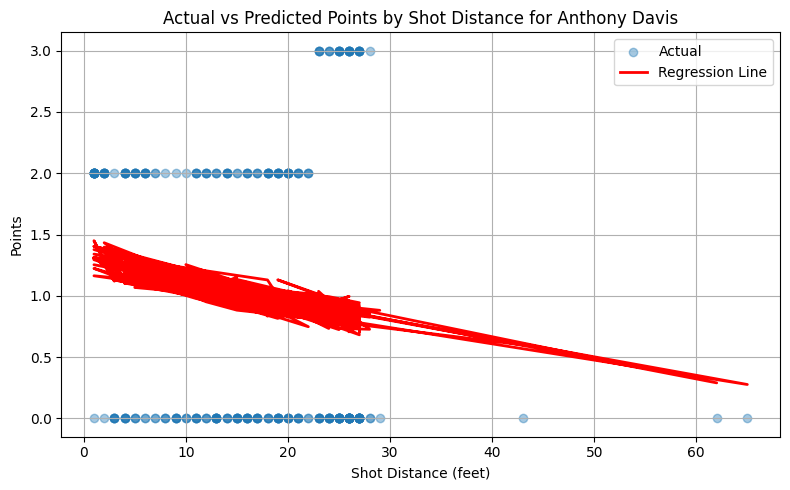

np.float64(1.0629313919241183)

In [340]:
linear_shot_predictor(df_ad_shot, example_shot, "Anthony Davis")

## KNN Shot Predictor (n = 5)

In [341]:
knn_shot_predictor(df_both_shot, example_shot)

Accuracy: 0.620125786163522
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       518
           1       0.45      0.43      0.44       277

    accuracy                           0.62       795
   macro avg       0.58      0.58      0.58       795
weighted avg       0.62      0.62      0.62       795

Predicted scoring probability: 20.00%


np.float64(0.2)

In [342]:
knn_shot_predictor(df_lebron_shot, example_shot)

Accuracy: 0.5245901639344263
              precision    recall  f1-score   support

           0       0.56      0.83      0.67        35
           1       0.33      0.12      0.17        26

    accuracy                           0.52        61
   macro avg       0.45      0.47      0.42        61
weighted avg       0.46      0.52      0.46        61

Predicted scoring probability: 40.00%


np.float64(0.4)

In [343]:
knn_shot_predictor(df_ad_shot, example_shot)

Accuracy: 0.5423728813559322
              precision    recall  f1-score   support

           0       0.58      0.59      0.58        32
           1       0.50      0.48      0.49        27

    accuracy                           0.54        59
   macro avg       0.54      0.54      0.54        59
weighted avg       0.54      0.54      0.54        59

Predicted scoring probability: 40.00%


np.float64(0.4)